In [1]:
import qstock as qs
import pandas as pd
import numpy as np
import quantstats as qst
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
def performance(df):
    cum_ret=df.apply(lambda x: ((x/x.shift(1)-1).fillna(0)+1.0).cumprod())
    total_ret=(cum_ret.iloc[-1]-1).sort_values(ascending=False)
    annual_ret=total_ret.apply(lambda x:pow(1+x,1/15)-1)
    dd=(cum_ret.cummax()-cum_ret)/cum_ret.cummax()
    d=dd.max()
    exReturn=df.apply(lambda x: (x/x.shift(1)-1).fillna(0)-0.03/250)
    sharper_atio=np.sqrt(len(exReturn))*exReturn.mean()/exReturn.std()
    perf_df=pd.DataFrame()
    perf_df['总收益率']=round(total_ret,3)
    perf_df['年化收益率%']=round(annual_ret*100,2)
    perf_df['最大回撤%']=round(d*100,2)
    perf_df['夏普比率']=round(sharper_atio,2)
    return perf_df

In [3]:
start_date='2010-01-01'
end_date='2023-05-17'
stock_codes=list(qs.index_member('hs300').sort_values('股票权重',ascending=False)['股票名称'])
stock_data = qs.get_price(stock_codes,start=start_date,end=end_date,fqt=2)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 26.29it/s]


In [4]:
perf_df=performance(stock_data)

In [5]:
perf_df

总收益率  年化收益率%  最大回撤%  夏普比率
亿纬锂能   32.002   26.25  63.56  2.55
片仔癀    30.687   25.91  53.50  2.92
隆基绿能   29.285   25.53  64.23  2.66
北方华创   22.831   23.54  71.36  2.42
天赐材料   22.389   23.39  75.41  2.46
...       ...     ...    ...   ...
一汽解放   -0.584   -5.69  78.95 -0.18
奇安信-U  -0.586   -5.71  70.65 -1.18
中国铝业   -0.594   -5.84  81.37 -0.24
申万宏源   -0.633   -6.46  71.87 -1.12
盐湖股份   -0.825  -10.95  87.96 -1.18

[300 rows x 4 columns]

In [6]:
perf_df.describe()

总收益率      年化收益率%       最大回撤%        夏普比率
count  300.000000  300.000000  300.000000  300.000000
mean     3.904000    7.458833   63.104933    1.038533
std      5.842648    7.454953   12.735680    0.907860
min     -0.825000  -10.950000   14.830000   -1.530000
25%      0.266250    1.585000   54.162500    0.390000
50%      1.608000    6.600000   64.595000    1.115000
75%      4.623000   12.197500   72.277500    1.715000
max     32.002000   26.250000   91.160000    2.920000

In [7]:
cum_ret=stock_data.apply(lambda x: ((x/x.shift(1)-1).fillna(0)+1.0).cumprod()).round(3)
total_ret=(cum_ret.iloc[-1]-1).sort_values(ascending=False)
qs.bar(total_ret[:10])

In [8]:
qs.bar(total_ret[-10:])

In [13]:
# 按月调仓，选择过去一年表现最好的60只股票
def enchanced_index_strategy(index_code='hs300',
                             start_date='2012-01-04', 
                             end_date= '2023-05-19',
                             transaction_cost=0.00,
                             slippage=0.00,
                             market_impact=0.00,
                             selection_threshold=0.2
                            ):
    start=(pd.to_datetime(start_date)-timedelta(365*2)).strftime('%Y-%m-%d')
    stock_codes = list(qs.index_member(index_code).sort_values('股票权重', ascending=False)['股票名称'])
    # 成分股后复权价格
    stock_data = qs.get_price(stock_codes, start=start, end=end_date, fqt=2)
    returns = stock_data.pct_change().fillna(0)
    # 月收益率
    monthly_returns = returns.resample('M').apply(lambda x: (x + 1).prod() - 1)
    
    month_ends = pd.date_range(start_date, end_date, freq='M')
    last_trading_day_of_month = [monthly_returns.index[
            monthly_returns.index.get_loc(month_end, method='pad')] 
                                 for month_end in month_ends]
    
    portfolio = {}
    for month_end in last_trading_day_of_month:
        if month_end not in monthly_returns.index:
            continue
        best_stocks = monthly_returns.loc[:month_end].last('1Y').mean().nlargest(int(len(stock_codes) * selection_threshold)).index
        portfolio[month_end] = best_stocks
    # 回测
    portfolio_returns = pd.Series(index=pd.to_datetime(list(portfolio.keys())))
    for date, stocks in portfolio.items():
        date_index = last_trading_day_of_month.index(date)
        if date_index + 1 < len(last_trading_day_of_month): 
            next_month_end = last_trading_day_of_month[date_index + 1]
            if next_month_end in monthly_returns.index:
                # 考虑摩擦
                portfolio_returns.loc[date] = monthly_returns.loc[next_month_end][stocks].mean() - transaction_cost - slippage - market_impact

    portfolio_returns = portfolio_returns.dropna()
    benchmark_returns=(qs.get_price(index_code,start=start_date,end=end_date)
           .pct_change().iloc[:,0].fillna(0))
    return portfolio_returns,benchmark_returns

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-31  2012-01-31
End Period                 2023-03-31  2023-03-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          961.21%     64.39%
CAGR﹪                     23.55%      4.55%

Sharpe                     4.13        1.4
Prob. Sharpe Ratio         99.85%      84.85%
Smart Sharpe               3.35        1.14
Sortino                    7.21        2.19
Smart Sortino              5.85        1.78
Sortino/√2                 5.1         1.55
Smart Sortino/√2           4.14        1.26
Omega                      2.01        2.01

Max Drawdown               -44.84%     -43.31%
Longest DD Days            1553        2011
Volatility (ann.)          127.19%     105.88%
R^2                        0.01        0.01
Information Ratio          0.15        0.15
Calmar                     0.53       

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2015-05-31  2016-01-31  2019-08-31  1553    -44.840374        -44.555210
2  2021-08-31  2022-11-30  2023-03-31   577    -36.779738        -36.154121
3  2012-05-31  2012-10-31  2012-12-31   214    -15.966423        -13.311188
4  2020-02-29  2020-02-29  2020-04-30    61    -14.050987         -3.016144
5  2021-01-31  2021-02-28  2021-04-30    89    -11.940460         -5.843928

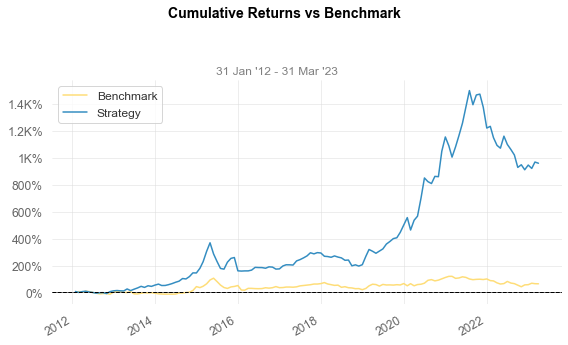

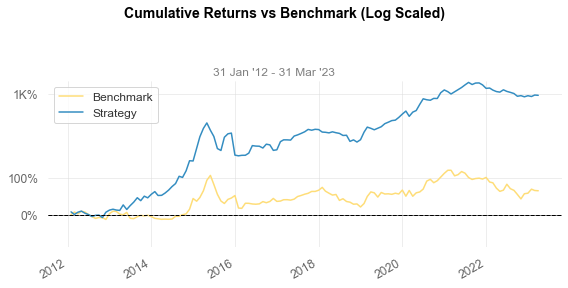

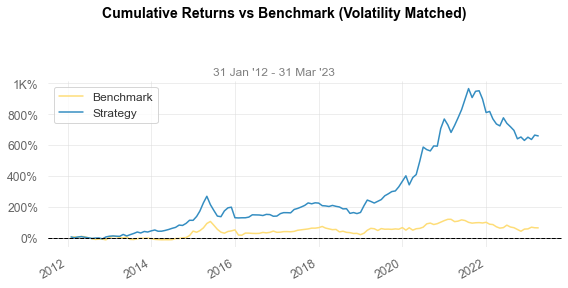

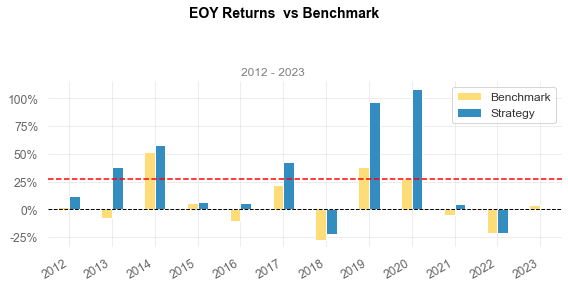

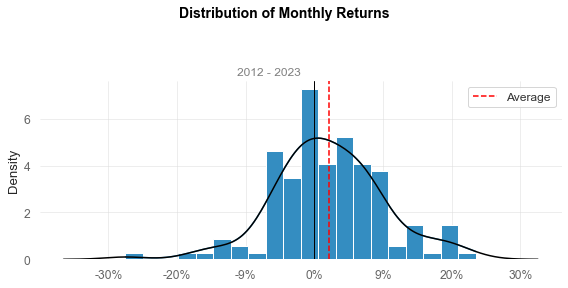

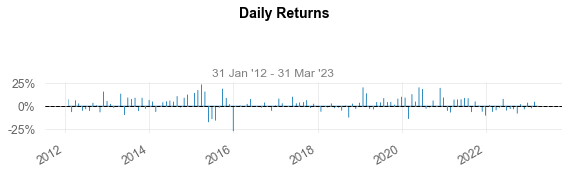

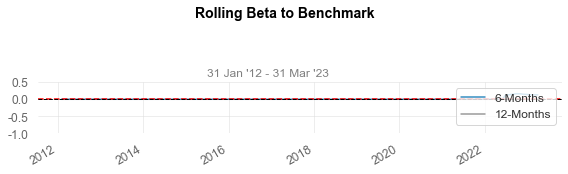

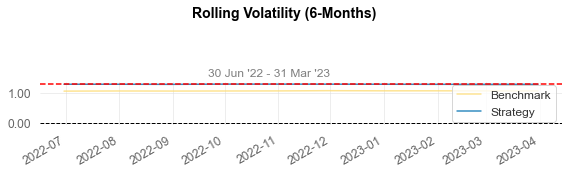

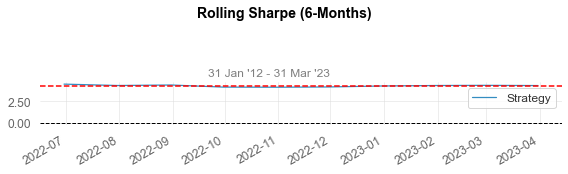

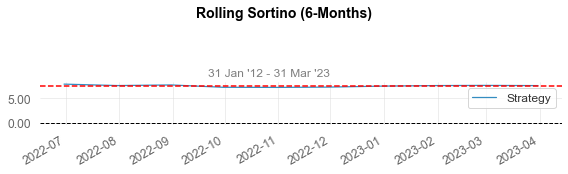

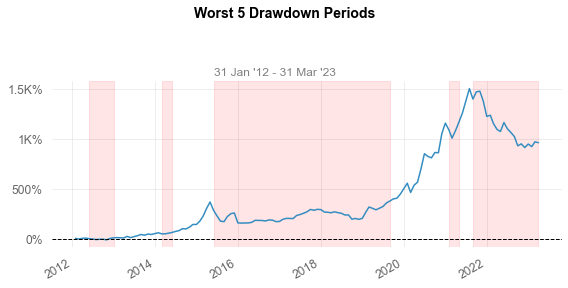

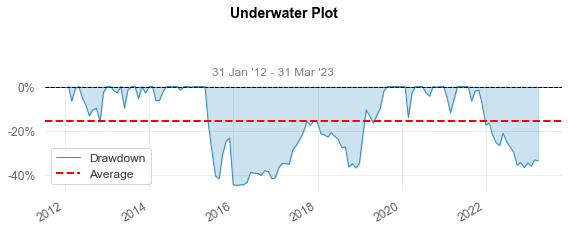

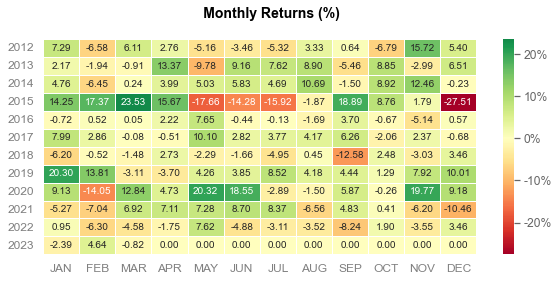

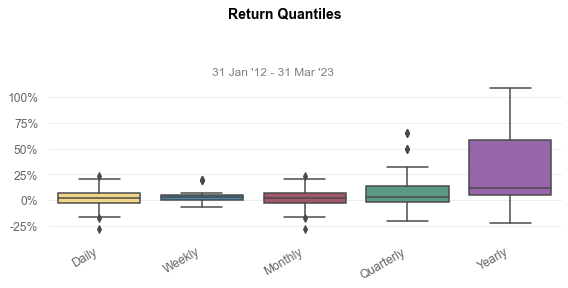

In [10]:
port_rets,ben_rets=enchanced_index_strategy('hs300')
qst.reports.full(port_rets,ben_rets)

 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [00:10<00:01, 33.49it/s]Exception in thread Thread-1231:
Traceback (most recent call last):
  File "D:\anaconda3\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "D:\anaconda3\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "D:\anaconda3\lib\site-packages\multitasking\__init__.py", line 104, in _run_via_pool
 88%|██████████████████████████████████████████████████████████████████████▋         | 265/300 [00:10<00:01, 25.32it/s]return callee(*args, **kwargs)
  File "D:\anaconda3\lib\site-packages\func_timeout\dafunc.py", line 185, in <lambda>
    return wraps(func)(lambda *args, **kwargs : func_timeout(defaultTimeout, func, args=args, kwargs=kwargs))
  File "D:\anaconda3\lib\site-packages\func_timeout\dafunc.py", line 101, in func_timeout
 90%|███████████████████████████████████████████████████████████████████████▋        | 269/300 [

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-31  2012-01-31
End Period                 2023-03-31  2023-03-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          643.69%     64.39%
CAGR﹪                     19.68%      4.55%

Sharpe                     3.61        1.4
Prob. Sharpe Ratio         99.53%      84.85%
Smart Sharpe               2.95        1.14
Sortino                    6.14        2.19
Smart Sortino              5.02        1.79
Sortino/√2                 4.34        1.55
Smart Sortino/√2           3.55        1.27
Omega                      1.84        1.84

Max Drawdown               -46.11%     -43.31%
Longest DD Days            1644        2011
Volatility (ann.)          126.67%     105.88%
R^2                        0.01        0.01
Information Ratio          0.12        0.12
Calmar                     0.43       

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2015-05-31  2016-01-31  2019-11-30  1644    -46.107027        -46.071314
2  2021-08-31  2022-11-30  2023-03-31   577    -39.191199        -38.950738
3  2012-05-31  2012-10-31  2012-12-31   214    -17.256541        -13.991300
4  2020-02-29  2020-02-29  2020-04-30    61    -14.211358         -3.411577
5  2021-01-31  2021-02-28  2021-05-31   120    -12.316932         -6.465671

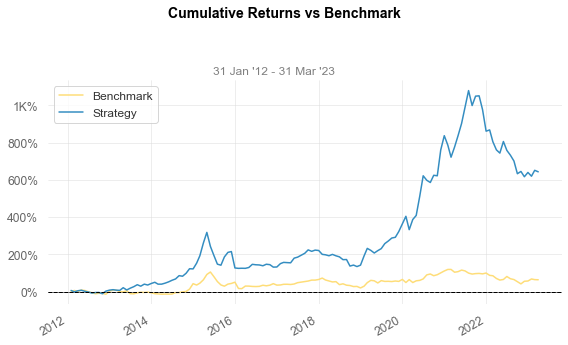

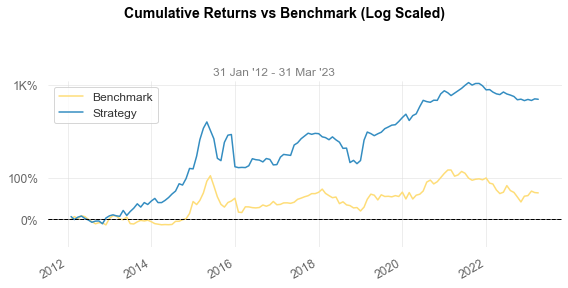

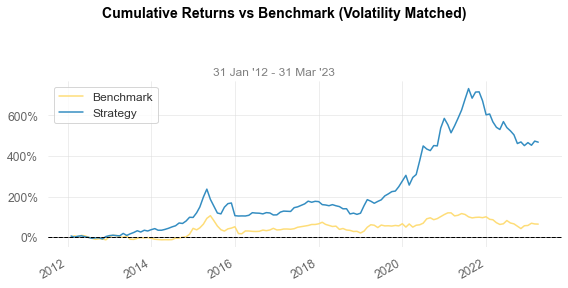

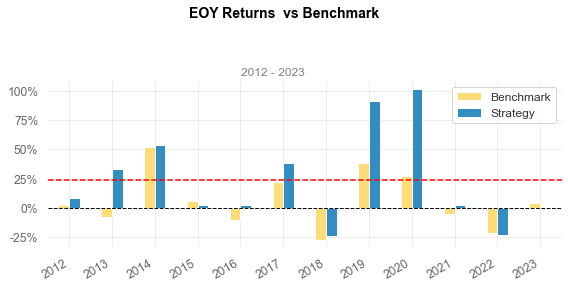

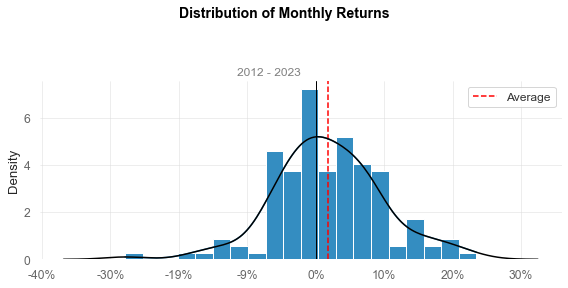

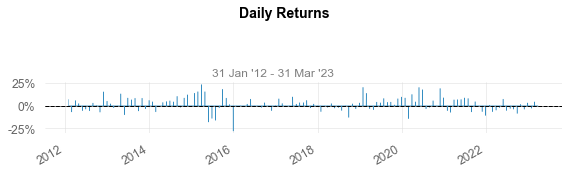

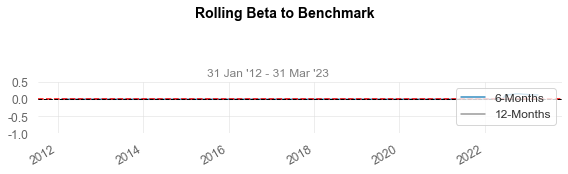

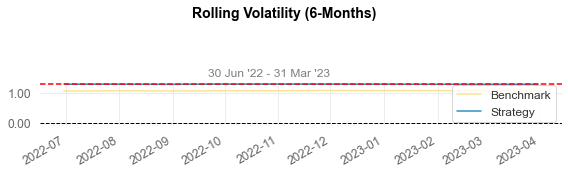

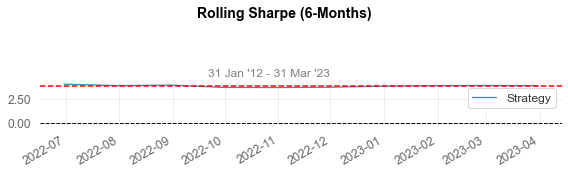

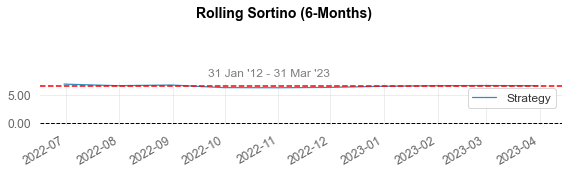

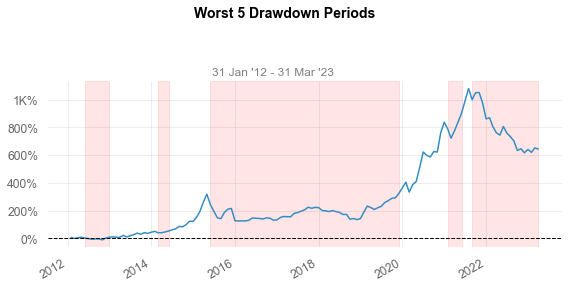

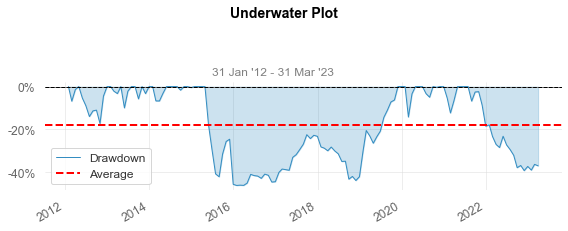

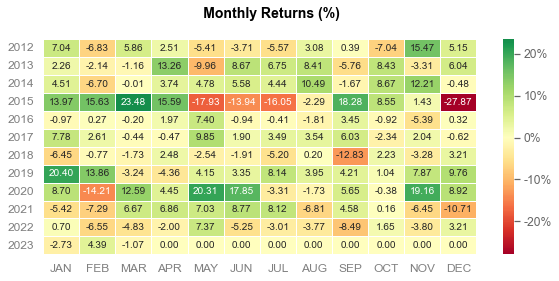

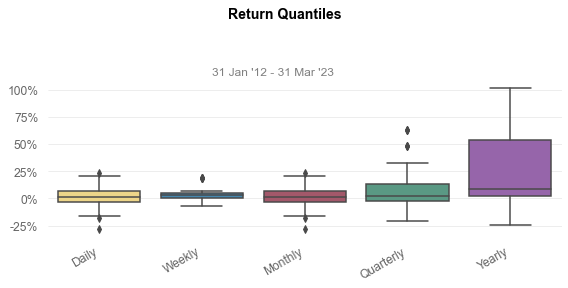

100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [00:30<00:00, 14.92it/s]

In [11]:
# 考虑TCA
port_rets,ben_rets=enchanced_index_strategy('hs300',
                             transaction_cost=0.0005,
                             slippage=0.001,
                             market_impact=0.001,)
qst.reports.full(port_rets,ben_rets)


100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [01:10<00:00,  4.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-31  2012-01-31
End Period                 2023-03-31  2023-03-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          1,074.45%   52.57%
CAGR﹪                     24.67%      3.85%

Sharpe                     3.9         1.25
Prob. Sharpe Ratio         99.84%      82.54%
Smart Sharpe               3.35        1.07
Sortino                    7.13        2.02
Smart Sortino              6.13        1.74
Sortino/√2                 5.04        1.43
Smart Sortino/√2           4.33        1.23
Omega                      1.98        1.98

Max Drawdown               -48.3%      -40.41%
Longest DD Days            823         1919
Volatility (ann.)          144.89%     111.13%
R^2                        0.02        0.02
Information Ratio          0.16        0.16
Calmar                     0.51      

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2021-08-31  2023-02-28  2023-03-31   577    -48.302686        -47.039399
2  2015-05-31  2016-01-31  2017-08-31   823    -41.404124        -41.375408
3  2018-05-31  2018-11-30  2019-02-28   273    -27.396399        -24.368805
4  2012-05-31  2012-10-31  2013-07-31   426    -20.022331        -18.439219
5  2020-02-29  2020-02-29  2020-05-31    92    -14.811171         -6.353310

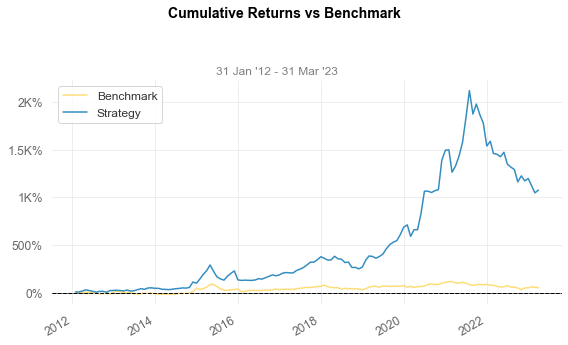

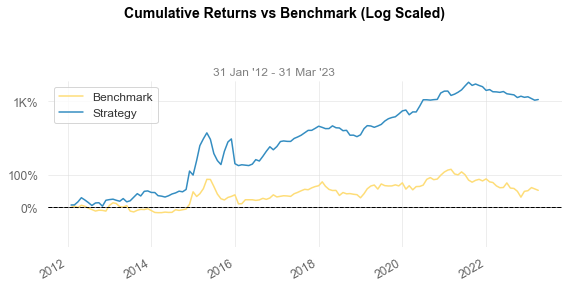

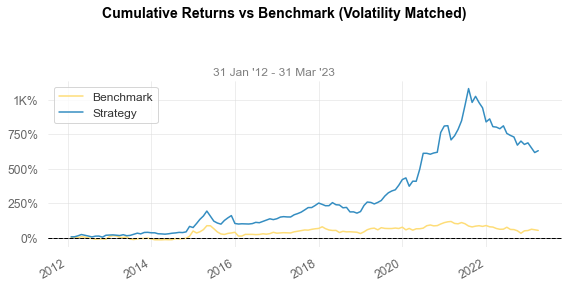

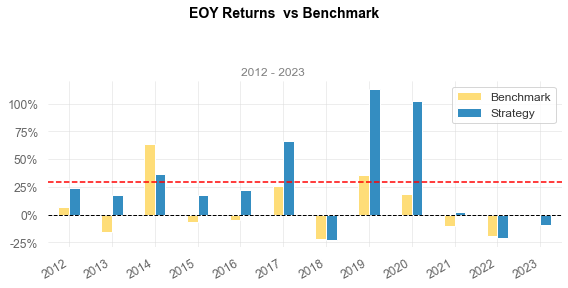

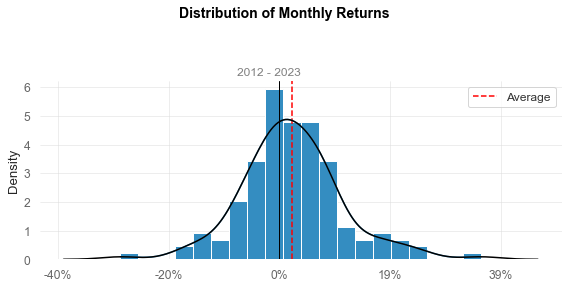

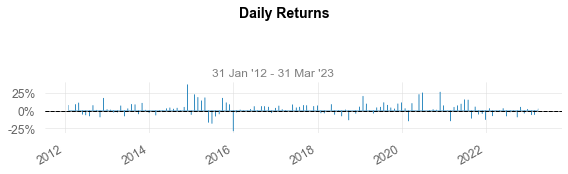

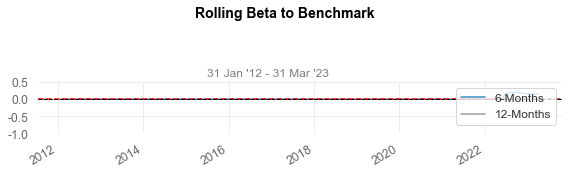

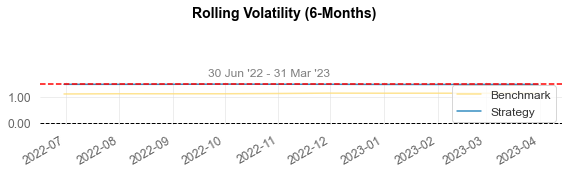

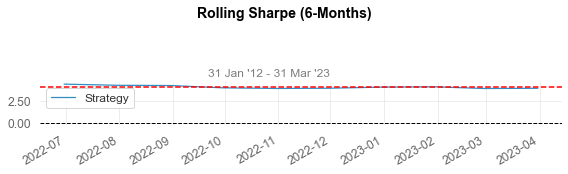

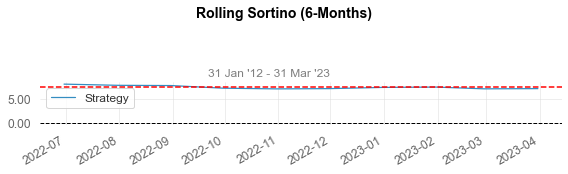

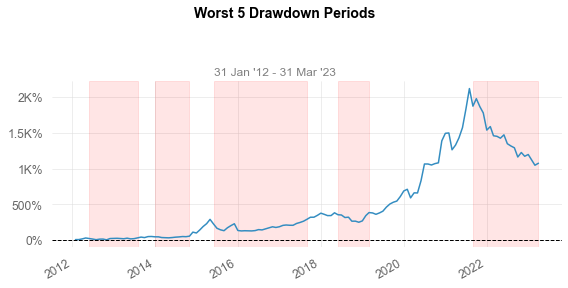

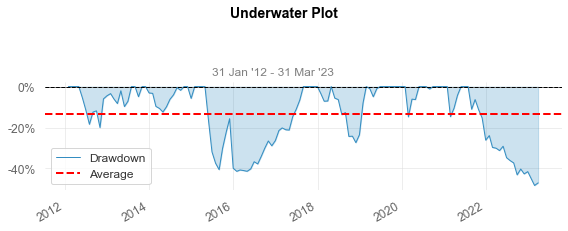

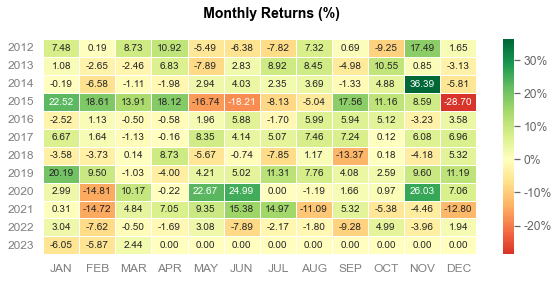

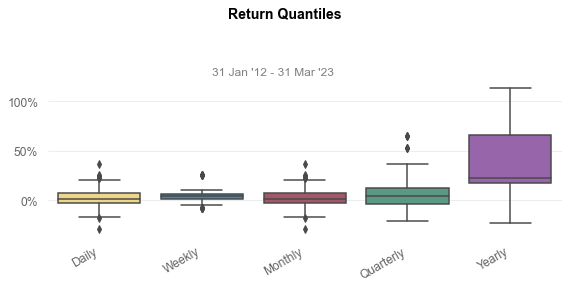

In [12]:
#上证50对比
port_rets,ben_rets=enchanced_index_strategy('sz50',
                             transaction_cost=0.0005,
                             slippage=0.001,
                             market_impact=0.001,)
qst.reports.full(port_rets,ben_rets)